In [1]:
import random
import torch
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [3]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cpu


## Data Acquisition

In [4]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_movies_from_csv(nrows=None):
    path = "movies.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)
    print(data.head())
    return data

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

In [5]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [6]:
ratings = get_ratings_from_csv()
movies = get_movies_from_csv()
print(ratings)

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
Loaded ml-25m data: ../../data/ml-25m/movies.csv
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5


In [7]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


In [8]:
# films = get_data_from_csv(f"{root}/{ratings}")[]


# DATA VISUALIZATION


In [9]:
            # # Fill in missing values with zeros
            # X.fillna(0, inplace=True)


# FARE TEST CON AVG, STD_DEV

In [104]:
def addColumnOperation(ratings,X):
     # Compute the mean rating for each user
     count_rating = ratings.groupby('movieId', as_index=False)['rating'].count()
     std= ratings.groupby('movieId', as_index=False)['rating'].std()
     std.fillna(0, inplace=True)
     min_ratings= ratings.groupby('movieId', as_index=False)['rating'].min()
     max_ratings= ratings.groupby('movieId', as_index=False)['rating'].max()
     median= ratings.groupby('movieId', as_index=False)['rating'].median()
     operation = pd.DataFrame({'movieId':count_rating['movieId'],'count_rating': count_rating['rating'], 'std': std['rating'], 'min': min_ratings['rating'], 'max': max_ratings['rating'], 'median': median['rating']}) 
     X = pd.merge(X, operation, on='movieId')
     return X
    
def preprocessing1(relevance, ratings):
     # Reduce genome-score size
     # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
     relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
     counting = relevance.groupby('movieId', as_index=False)['relevance'].count()
     print(counting)
     # Merge the ratings and relevance data
     mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
     X = mean_ratings.merge(relevance_matrix, on='movieId')
     #X = addColumnOperation(ratings,X)
     X.columns = X.columns.astype(str)
     ratings = None  
     # mescolare le righe del DataFrame
     #X = X.sample(frac=1).reset_index(drop=True)
     
     y = X['rating']
     X.drop("movieId", axis=1, inplace=True)
     X = X.drop('rating', axis=1)
     return X,y

def preprocessing2(movies,relevance, ratings):
     # Merge the ratings and movies data
     #X = ratings.merge(movies, on='movieId')
     movies_genres = movies['genres'].str.split( '|')
     m = pd.get_dummies(movies_genres.apply(pd.Series).stack()).sum(level=0)
     movies_genres = pd.concat([movies['movieId'], m], axis=1)

     relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
     mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
     
     X = mean_ratings.merge(movies_genres, on='movieId')
     X = X.merge(relevance_matrix, on='movieId')
     X.columns = X.columns.astype(str)
     ratings = None  
     # mescolare le righe del DataFrame
     #X = X.sample(frac=1).reset_index(drop=True)
     
     y = X['rating']
     X.drop("movieId", axis=1, inplace=True)
     X = X.drop('rating', axis=1)
     
     # Apply PCA if n_components is specified
     pca = PCA()
     X = pca.fit_transform(X)
     return X,y

In [113]:
class LinearRegressionModel:
    def __init__(self, ratings, relevance,movies, seed=42):
        import matplotlib.pyplot as plt
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        #X = addColumnOperation(ratings,X)
        X.columns = X.columns.astype(str)
        ratings = None  
        # mescolare le righe del DataFrame
        X = X.sample(frac=1).reset_index(drop=True)
        
        y = X['rating']
        X.drop("movieId", axis=1, inplace=True)
        X = X.drop('rating', axis=1)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

        pca = PCA()
        pca.fit(self.X_train)
        self.X_train_t = pca.transform(self.X_train)
        self.X_test_t = pca.transform(self.X_test)
        print(self.X_train)
        print(self.X_train_t)
        plt.scatter(self.X_train_t[:, 0], self.X_train_t[:, 1], c=self.y_train, cmap='viridis')
        plt.show()
        
        plt.scatter(self.X_test_t[:, 0], self.X_test_t[:, 1], c=self.y_test, cmap='viridis')
        plt.show()
        # Initialize the Gaussian Naive Bayes model
        self.model = LinearRegression()

        # Set the hyperparameters for tuning
        self.params = {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'positive': [True, False]
        }

    def train(self):
        # Fit the model to the training data
        self.tuning(self.X_train, self.y_train)
        self.model.fit(self.X_train, self.y_train)
        print("Modello fittato senza PCA transformation")
        self.test(self.X_test)
        self.model.fit(self.X_train_t, self.y_train)
        print("Modello fittato con PCA transformation")
        self.test(self.X_test_t)
    
     # Hyperparameter tuning
    def tuning(self,X,y):
        grid_search = GridSearchCV(self.model, param_grid=self.params, cv=3, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.4f}")
        
        # Re-initialize the model with the best hyperparameters
        #self.model = LinearRegression(**grid_search.best_params_)


    def test(self, X_test):
        # Predict ratings for the test data
        y_pred = self.model.predict(X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        score = self.model.score(X_test, self.y_test)
        print(f"Score:{score}")
        print("Intercept: "+str( self.model.intercept_))
        print("Coefficients: "+ str(self.model.coef_))


(11052, 1128) (2764, 1128) (11052,) (2764,)
             1        2        3        4        5        6        7        8  \
10042  0.03450  0.02975  0.02375  0.02200  0.05100  0.01900  0.01600  0.03025   
7698   0.02875  0.02875  0.02725  0.05075  0.05000  0.08250  0.09950  0.27050   
11955  0.02125  0.02450  0.05450  0.12175  0.20300  0.19650  0.15100  0.42450   
10365  0.16300  0.19825  0.32625  0.39425  0.55425  0.22325  0.28050  0.73325   
1888   0.03550  0.03250  0.02400  0.03600  0.04150  0.04000  0.01250  0.05925   
...        ...      ...      ...      ...      ...      ...      ...      ...   
7554   0.01450  0.01675  0.01900  0.04700  0.02800  0.01400  0.06100  0.02650   
8752   0.02425  0.02875  0.12400  0.16175  0.09100  0.13150  0.03450  0.10275   
13034  0.02825  0.02925  0.06875  0.12275  0.32775  0.13800  0.10075  0.24050   
6798   0.01975  0.02150  0.05200  0.05525  0.07375  0.06425  0.10175  0.27400   
9066   0.04000  0.04200  0.02600  0.03725  0.05325  0.02450  0.02

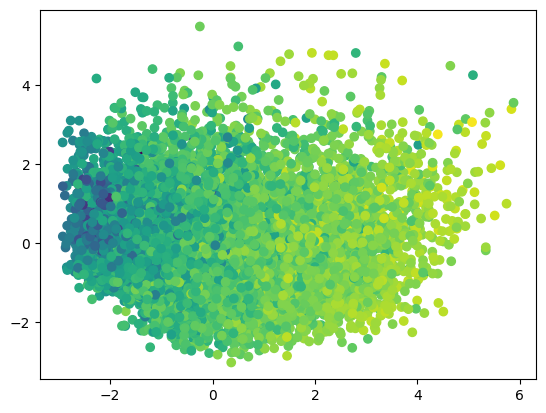

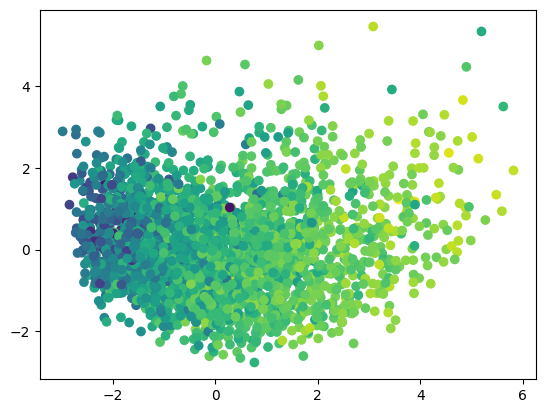

In [114]:
lr = LinearRegressionModel(ratings,genome_scores,movies, SEED)

In [115]:
lr.train()

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best score: -0.0055
Modello fittato senza PCA transformation
MSE: 0.005427047988034109 RMSE: 0.0736685006501022 R2: 0.977072501056869 MAE: 0.05669574395599297
Score:0.977072501056869
Intercept: 3.5371855817992075
Coefficients: [ 1.29098343e-03 -6.38582352e-02 -2.62904668e-05 ... -3.28318152e-02
 -1.31475977e-01  1.00060087e-01]
Modello fittato con PCA transformation
MSE: 0.0054270479880341145 RMSE: 0.07366850065010225 R2: 0.9770725010568689 MAE: 0.056695743955993014
Score:0.9770725010568689
Intercept: 3.273730126342623
Coefficients: [ 0.21992472 -0.04057946  0.13495358 ...  0.07408906 -0.17454394
  0.11372274]


In [116]:
#lr.test()